In [ ]:
# 1. Imports and Data Loading
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
import joblib

# Load dataset
file_path = "data/HPC2N-2002-2.2-cln.swf"
df = pd.read_csv(
    file_path,
    sep=r'\s+',
    comment=';',
    header=None,
    engine='python'
)
# Assign SWF column names
swf_cols = [
    'job_id', 'submit_time', 'wait_time', 'run_time', 'allocated_cpu', 'used_cpu',
    'requested_mem', 'used_mem', 'requested_time', 'status', 'user_id', 'group_id',
    'executable_num', 'queue_name', 'partition', 'preceding_job_id', 'think_time', 'placeholder'
]
df.columns = swf_cols

In [8]:
# 2. Feature Selection and Data Cleaning
# Remove jobs with missing or invalid targets
for col in ['run_time', 'used_mem']:
    df = df[df[col].notnull() & (df[col] > 0)]

# Feature engineering: add temporal and submission-available features
# (No leakage: only use features available before job starts)
df['hour_of_day'] = df['submit_time'] % 86400 // 3600
# If submit_time is in seconds since epoch, day_of_week as below:
df['day_of_week'] = (df['submit_time'] // 86400) % 7

# Define feature sets for each model (all pre-runtime features, no post-execution info)
pre_runtime_features = [
    'submit_time', 'requested_mem', 'requested_time', 'user_id', 'group_id',
    'executable_num', 'queue_name', 'partition', 'hour_of_day', 'day_of_week'
]

# Remove any columns not present in df (for robustness)
pre_runtime_features = [f for f in pre_runtime_features if f in df.columns]

X_rt = df[pre_runtime_features].copy()
X_mem = df[pre_runtime_features].copy()

# Targets
y_runtime = df['run_time']
y_memory = df['used_mem']

In [9]:
# 3. Train/Test Split (time-ordered, no shuffle)
X_train_rt, X_test_rt, y_train_rt, y_test_rt = train_test_split(
    X_rt, y_runtime, test_size=0.2, shuffle=False)
X_train_mem, X_test_mem, y_train_mem, y_test_mem = train_test_split(
    X_mem, y_memory, test_size=0.2, shuffle=False)

In [10]:
# 4. Preprocessing Pipeline
# Identify numeric and categorical columns
numeric_features_rt = X_rt.select_dtypes(include=[np.number]).columns.tolist()
categorical_features_rt = X_rt.select_dtypes(include=['object']).columns.tolist()
numeric_features_mem = X_mem.select_dtypes(include=[np.number]).columns.tolist()
categorical_features_mem = X_mem.select_dtypes(include=['object']).columns.tolist()

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor_rt = ColumnTransformer([
    ('num', numeric_transformer, numeric_features_rt),
    ('cat', categorical_transformer, categorical_features_rt)
])
preprocessor_mem = ColumnTransformer([
    ('num', numeric_transformer, numeric_features_mem),
    ('cat', categorical_transformer, categorical_features_mem)
])

In [11]:
# 5. Model Pipelines and Hyperparameter Grids
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
base_pipeline_rt = Pipeline([
    ('preprocessor', preprocessor_rt),
    ('model', XGBRegressor(objective='reg:squarederror', random_state=42))
])
base_pipeline_mem = Pipeline([
    ('preprocessor', preprocessor_mem),
    ('model', XGBRegressor(objective='reg:squarederror', random_state=42))
])

param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [4, 6],
    'model__learning_rate': [0.1, 0.01]
}

In [12]:
# 6. Runtime Prediction Model
from sklearn.model_selection import TimeSeriesSplit
cv = TimeSeriesSplit(n_splits=3)
grid_search_rt = GridSearchCV(
    base_pipeline_rt, param_grid, cv=cv, n_jobs=-1, verbose=1
)
grid_search_rt.fit(X_train_rt, y_train_rt)
best_rt = grid_search_rt.best_estimator_
y_pred_rt = best_rt.predict(X_test_rt)
r2_rt = r2_score(y_test_rt, y_pred_rt)
print(f"Runtime R^2: {r2_rt:.3f}")

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Runtime R^2: 0.358
Runtime R^2: 0.358


In [13]:
# 7. Memory Usage Prediction Model
cv = TimeSeriesSplit(n_splits=3)
grid_search_mem = GridSearchCV(
    base_pipeline_mem, param_grid, cv=cv, n_jobs=-1, verbose=1
)
grid_search_mem.fit(X_train_mem, y_train_mem)
best_mem = grid_search_mem.best_estimator_
y_pred_mem = best_mem.predict(X_test_mem)
r2_mem = r2_score(y_test_mem, y_pred_mem)
print(f"Memory R^2: {r2_mem:.3f}")

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Memory R^2: 0.133
Memory R^2: 0.133


Runtime MAE: 23275.68, RMSE: 51154.34
Memory MAE: 4.15, RMSE: 6.67


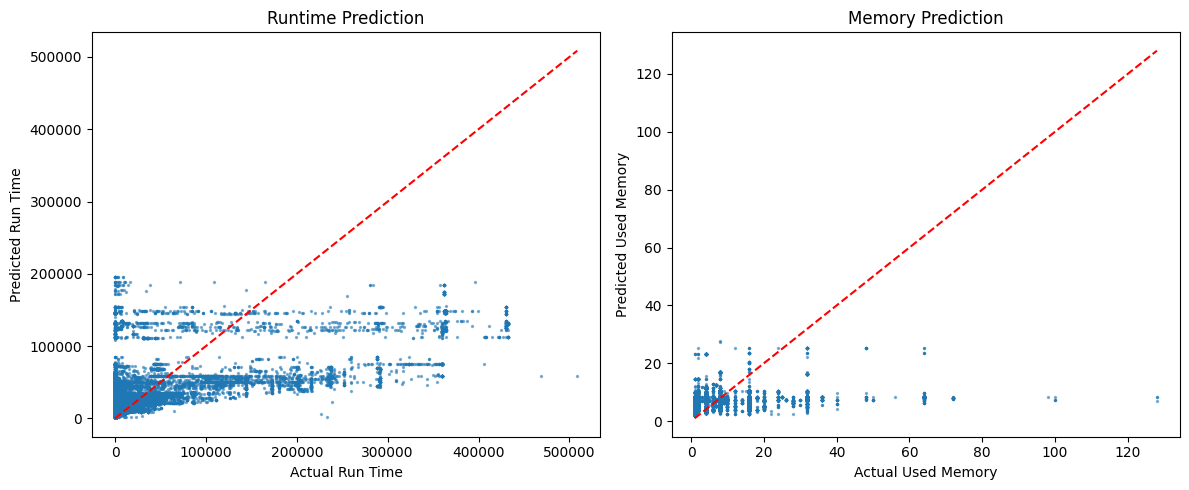

In [14]:
# 8. Model Evaluation and Diagnostics
mae_rt = mean_absolute_error(y_test_rt, y_pred_rt)
rmse_rt = np.sqrt(mean_squared_error(y_test_rt, y_pred_rt))
print(f"Runtime MAE: {mae_rt:.2f}, RMSE: {rmse_rt:.2f}")
mae_mem = mean_absolute_error(y_test_mem, y_pred_mem)
rmse_mem = np.sqrt(mean_squared_error(y_test_mem, y_pred_mem))
print(f"Memory MAE: {mae_mem:.2f}, RMSE: {rmse_mem:.2f}")

plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.scatter(y_test_rt, y_pred_rt, s=2, alpha=0.5)
plt.plot([y_test_rt.min(), y_test_rt.max()], [y_test_rt.min(), y_test_rt.max()], 'r--')
plt.xlabel("Actual Run Time")
plt.ylabel("Predicted Run Time")
plt.title("Runtime Prediction")
plt.subplot(1, 2, 2)
plt.scatter(y_test_mem, y_pred_mem, s=2, alpha=0.5)
plt.plot([y_test_mem.min(), y_test_mem.max()], [y_test_mem.min(), y_test_mem.max()], 'r--')
plt.xlabel("Actual Used Memory")
plt.ylabel("Predicted Used Memory")
plt.title("Memory Prediction")
plt.tight_layout()
plt.show()

In [15]:
# 9. Save Best Models
import os
os.makedirs("../models", exist_ok=True)
joblib.dump(best_rt, "../models/xgb_runtime_model.joblib")
joblib.dump(best_mem, "../models/xgb_memory_model.joblib")

['../models/xgb_memory_model.joblib']

# PPO Scheduler 

In [ ]:
# ...existing PPO scheduler code from original pipelinev1 remains unchanged...
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import random
import pandas as pd

class HPCEnv(gym.Env):
    def __init__(self, job_data, max_cpus=128, max_mem=1024):
        super().__init__()
        self.job_data = job_data
        self.job_queue = job_data.copy()
        self.max_cpus = max_cpus
        self.max_mem = max_mem
        self.state = np.array([self.max_cpus, self.max_mem], dtype=np.float32)
        self.queue_size = 20
        self.action_space = spaces.Discrete(self.queue_size)
        self.observation_space = spaces.Box(
            low=0, high=np.inf, shape=(self.queue_size * 2 + 2,), dtype=np.float32
        )
        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_time = 0
        if len(self.job_queue) < self.queue_size:
            self.queue = self.job_queue.copy().reset_index(drop=True)
        else:
            self.queue = self.job_queue.sample(n=self.queue_size, random_state=seed).reset_index(drop=True)
        self.running_jobs = []
        self.state = np.array([self.max_cpus, self.max_mem], dtype=np.float32)
        return self._get_obs(), {}

    def _get_obs(self):
        job_features = self.queue[['run_time', 'used_mem']].fillna(0).values.flatten()
        current_queue_size = len(self.queue)
        padding_size = (self.queue_size - current_queue_size) * 2
        if padding_size > 0:
            padding = np.zeros(padding_size, dtype=np.float32)
            job_features = np.concatenate([job_features, padding])
        state = np.concatenate([job_features, self.state])
        return state.astype(np.float32)

    def step(self, action):
        done = False
        reward = 0
        info = {}
        if action >= len(self.queue):
            reward = -10
        else:
            job = self.queue.iloc[int(action)]
            required_cpus = 1
            required_mem = job['used_mem']
            duration = job['run_time']
            if self.state[0] >= required_cpus and self.state[1] >= required_mem:
                self.state[0] -= required_cpus
                self.state[1] -= required_mem
                self.running_jobs.append({
                    'end_time': self.current_time + duration,
                    'cpus': required_cpus,
                    'mem': required_mem
                })
                reward = 10
                self.queue.drop(index=int(action), inplace=True)
                self.queue.reset_index(drop=True, inplace=True)
            else:
                reward = -1
        self.current_time += 1
        self._update_running_jobs()
        terminated = len(self.queue) == 0
        truncated = self.current_time > 500
        done = terminated or truncated
        return self._get_obs(), reward, terminated, truncated, info

    def _update_running_jobs(self):
        finished = [j for j in self.running_jobs if j['end_time'] <= self.current_time]
        for job in finished:
            self.state[0] += job['cpus']
            self.state[1] += job['mem']
        self.running_jobs = [j for j in self.running_jobs if j['end_time'] > self.current_time]

In [ ]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env

df_jobs = pd.DataFrame({
    'run_time': y_pred_rt,
    'used_mem': y_pred_mem
})

env = HPCEnv(job_data=df_jobs)
check_env(env, warn=True)

model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000)

# Evaluate PPO agent
obs, _ = env.reset()
total_reward = 0
for _ in range(100):
    action, _ = model.predict(obs)
    obs, reward, terminated, truncated, _ = env.step(action)
    total_reward += reward
    if terminated or truncated:
        break
print("Total reward from 1 test episode:", total_reward)

# Save PPO model
model.save("../models/ppo_hpc_scheduler")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 65.5     |
|    ep_rew_mean     | -255     |
| time/              |          |
|    fps             | 790      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 65.5     |
|    ep_rew_mean     | -255     |
| time/              |          |
|    fps             | 790      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 64.9        |
|    ep_rew_mean          | -249        |
| time/                   |             |
|    fps        